In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
#import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import io

In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
tf.__version__

'2.1.0'

In [5]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 183475578843983015
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 704628537416620166
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2618937193230282162
physical_device_desc: "device: XLA_GPU device"
]


In [6]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [7]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [8]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [9]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [10]:
# for i in range(20):
#     plt.imshow(projections[i])
#     plt.tight_layout()
#     plt.savefig(f"/mnt/scratch/students/{angles_true[i]}.JPG")

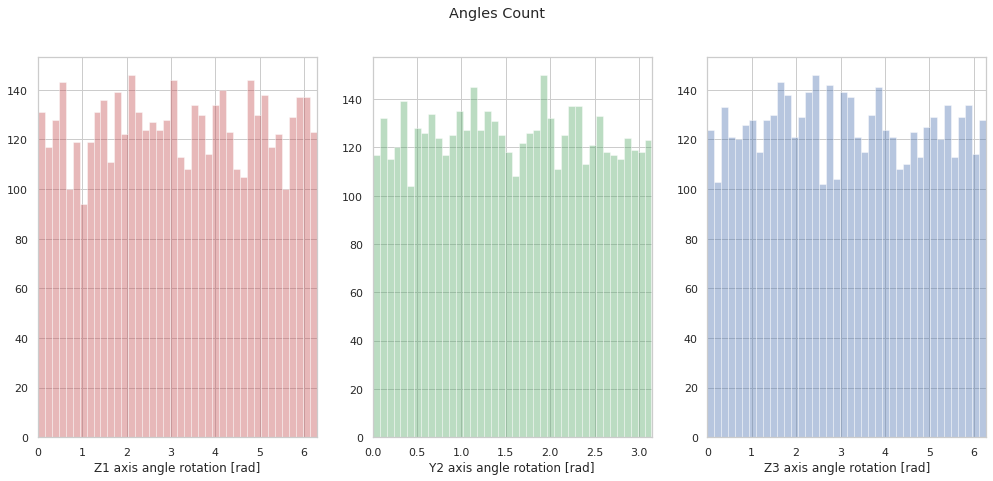

In [11]:
plot_angles_count(angles_true)

In [12]:
from cryoem.distance_estimation import global_standardization

In [13]:
X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [14]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.038
Min:  0.000 | Max: 15.440
Mean: 0.000 | Std: 1.000
Min:  -0.252 | Max: 14.627


In [15]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

---

## Angle Recovery: Estimated Distance

In [16]:
model_filename = "training/noisy_var0.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [17]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [18]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [19]:
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

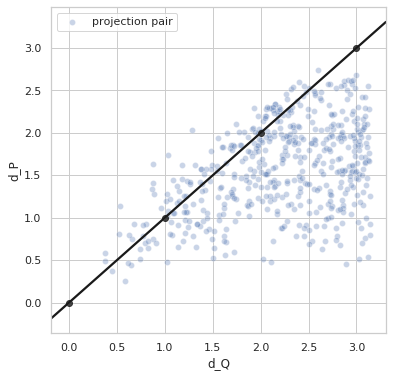

<Figure size 432x288 with 0 Axes>

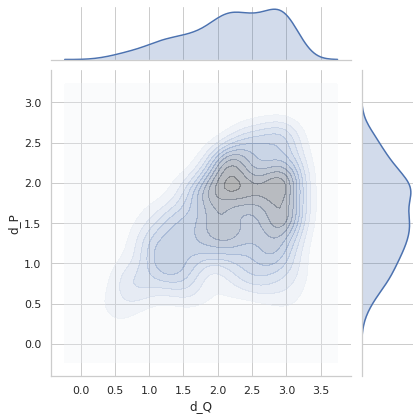

Variance = 0.9067623518039221
Min. angle recovery loss possible = 0.820612068190681


In [20]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [21]:
from cryoem.angle_recovery import train_angle_recovery

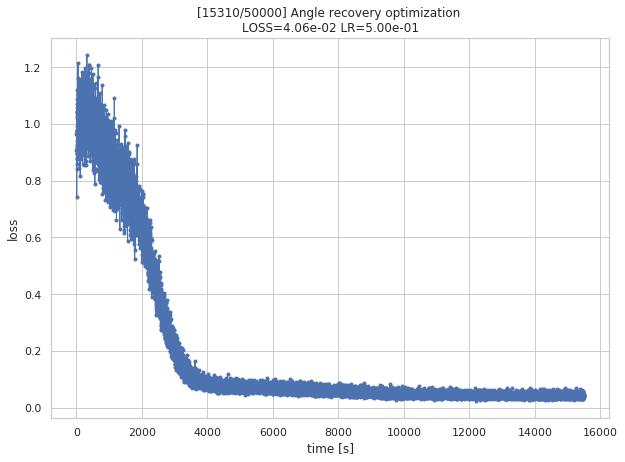

Shape of projections: (5000, 116, 116, 1)step 5000/50000 (4941s): loss = 7.41e-02
step 10000/50000 (9972s): loss = 5.77e-02
step 15000/50000 (15162s): loss = 4.16e-02
step 15310/50000 (15491s): loss = 3.96e-02



In [22]:
q_predicted, losses, q_all = train_angle_recovery(steps=50000, 
                             batch_size=256, 
                             in_data=X, 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             limit_distance=np.pi,                
                             low_ang_const=[0.0, 0.0, 0.0],
                             high_ang_const=[2.0, 0.4, 2.0],
                             file_name="data/5j0n/angle_recovery_full4_limited3.14_estimated_50k")

In [23]:
from cryoem.conversions import quaternion2euler

In [24]:
data = np.load("data/5j0n/angle_recovery_full4_limited3.14_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

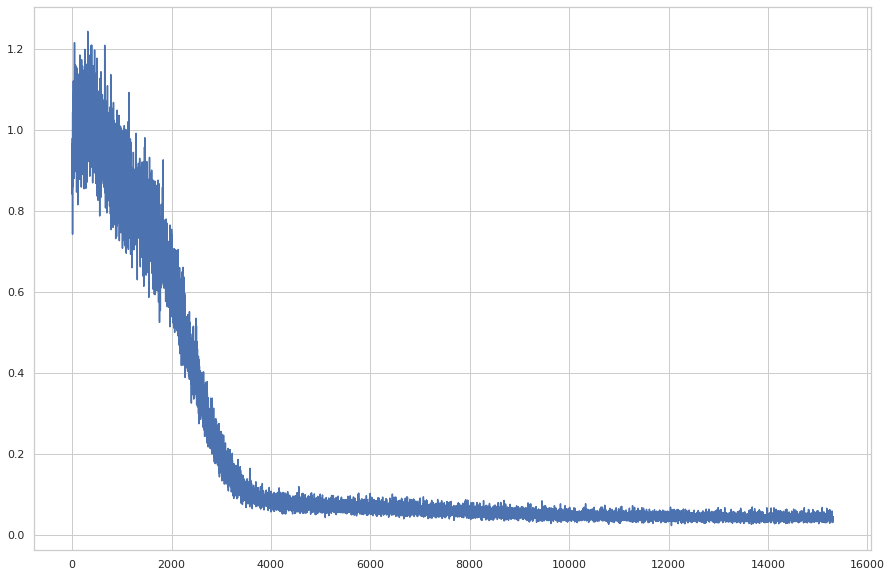

In [25]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[losses>1e-6])
plt.show()

In [26]:
np.mean(losses[losses>1e-6][-10:])

0.04063913046029223

In [27]:
#np.save("data/5j0n/projections_limited2.5_estimated_50k", projections)
#np.save("data/5j0n/angles_true_limited2.5_estimated_50k", angles_true)
#np.save("data/5j0n/angles_predicted_full_limited3.14_estimated_50k", angles_predicted)

In [28]:
q_predicted

array([[ 0.39936425,  0.18576568, -0.18631754,  0.87822838],
       [-0.40440239, -0.1069064 ,  0.08573688, -0.904256  ],
       [-0.31421052, -0.17032863,  0.10564815, -0.92795386],
       ...,
       [-0.21239028, -0.05042106, -0.53149828,  0.81844833],
       [-0.2542006 , -0.35704539, -0.57751514,  0.68875025],
       [-0.51971662,  0.02016254, -0.21663865,  0.82616935]])

(array([139., 333., 654., 692., 718., 712., 706., 664., 333.,  49.]),
 array([-0.81775816, -0.64647101, -0.47518386, -0.30389671, -0.13260956,
         0.03867759,  0.20996473,  0.38125188,  0.55253903,  0.72382618,
         0.89511333]),
 <a list of 10 Patch objects>)

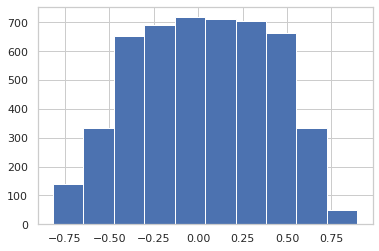

In [29]:
plt.hist(q_predicted[:,0])

(array([167., 509., 558., 685., 658., 658., 678., 538., 483.,  66.]),
 array([-0.73540647, -0.5851781 , -0.43494973, -0.28472136, -0.13449298,
         0.01573539,  0.16596376,  0.31619213,  0.46642051,  0.61664888,
         0.76687725]),
 <a list of 10 Patch objects>)

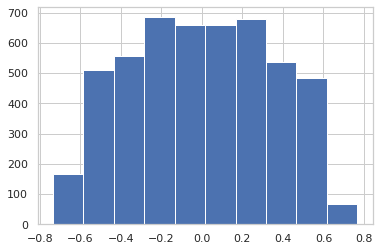

In [30]:
plt.hist(q_predicted[:,1])

(array([ 68., 301., 569., 803., 898., 874., 727., 470., 245.,  45.]),
 array([-0.69742762, -0.55862354, -0.41981945, -0.28101536, -0.14221127,
        -0.00340719,  0.1353969 ,  0.27420099,  0.41300508,  0.55180917,
         0.69061325]),
 <a list of 10 Patch objects>)

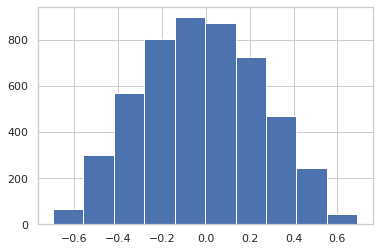

In [31]:
plt.hist(q_predicted[:,2])

(array([1238.,  716.,   98.,    0.,    0.,    0.,    0.,  106., 1039.,
        1803.]),
 array([-9.98130130e-01, -7.98540899e-01, -5.98951667e-01, -3.99362435e-01,
        -1.99773204e-01, -1.83972315e-04,  1.99405259e-01,  3.98994491e-01,
         5.98583722e-01,  7.98172954e-01,  9.97762186e-01]),
 <a list of 10 Patch objects>)

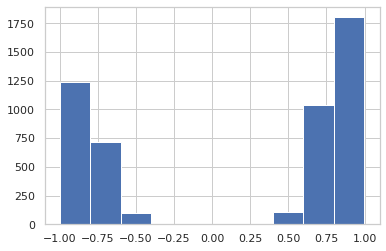

In [32]:
plt.hist(q_predicted[:,3])

In [33]:
q_true = euler2quaternion(angles_true)

(array([362., 363., 453., 539., 822., 755., 533., 474., 374., 325.]),
 array([-9.99575147e-01, -7.99617944e-01, -5.99660741e-01, -3.99703537e-01,
        -1.99746334e-01,  2.10869269e-04,  2.00168073e-01,  4.00125276e-01,
         6.00082479e-01,  8.00039683e-01,  9.99996886e-01]),
 <a list of 10 Patch objects>)

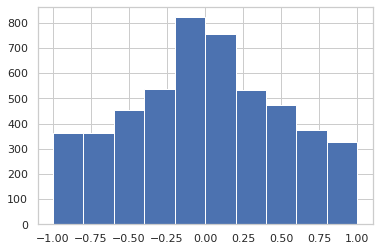

In [34]:
plt.hist(q_true[:,0])

(array([329., 395., 419., 549., 823., 846., 540., 407., 381., 311.]),
 array([-9.99292286e-01, -7.99518979e-01, -5.99745671e-01, -3.99972364e-01,
        -2.00199057e-01, -4.25749185e-04,  1.99347558e-01,  3.99120866e-01,
         5.98894173e-01,  7.98667480e-01,  9.98440788e-01]),
 <a list of 10 Patch objects>)

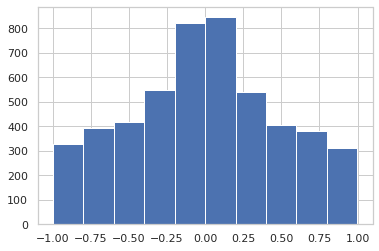

In [35]:
plt.hist(q_true[:,1])

(array([343., 390., 451., 504., 810., 793., 536., 447., 393., 333.]),
 array([-9.99667960e-01, -7.99807447e-01, -5.99946933e-01, -4.00086419e-01,
        -2.00225906e-01, -3.65392202e-04,  1.99495121e-01,  3.99355635e-01,
         5.99216149e-01,  7.99076662e-01,  9.98937176e-01]),
 <a list of 10 Patch objects>)

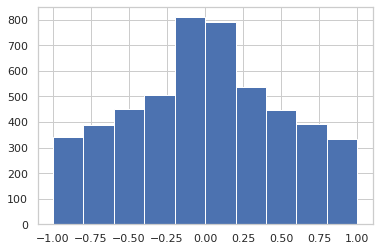

In [36]:
plt.hist(q_true[:,2])

(array([971., 659., 563., 543., 448., 442., 350., 327., 367., 330.]),
 array([1.17153575e-05, 1.00004566e-01, 1.99997417e-01, 2.99990268e-01,
        3.99983118e-01, 4.99975969e-01, 5.99968820e-01, 6.99961671e-01,
        7.99954521e-01, 8.99947372e-01, 9.99940223e-01]),
 <a list of 10 Patch objects>)

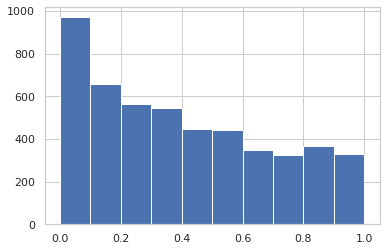

In [37]:
plt.hist(q_true[:,3])

In [38]:
q_predicted_dc = np.empty(q_predicted.shape)

for i, q in enumerate(q_predicted):
    q_predicted_dc[i] = q if q[3]>0 else -q

(array([   8.,   54.,  117.,  207.,  536.,  639.,  779., 1230., 1012.,
         418.]),
 array([0.41441173, 0.47278357, 0.53115541, 0.58952725, 0.64789909,
        0.70627093, 0.76464277, 0.82301461, 0.88138645, 0.93975829,
        0.99813013]),
 <a list of 10 Patch objects>)

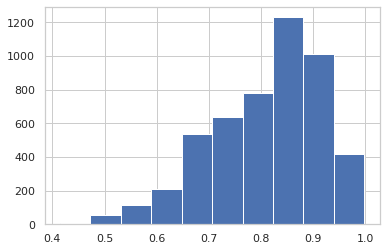

In [39]:
plt.hist(q_predicted_dc[:,3])

In [40]:
angles_predicted_dc = quaternion2euler(q_predicted_dc)

### Angle Alignment

In [41]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl
from cryoem.angle_recovery import angles_transpose

In [44]:
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec, plot_rotvec, plot_euclidean_space, plot_only_selected_in_euclidean_space

In [45]:
plot_rotvec(angles_predicted_dc.numpy())

In [61]:
#angles_true_half = np.load("/mnt/scratch/students/5j0n_angles_true_translation5.npy")

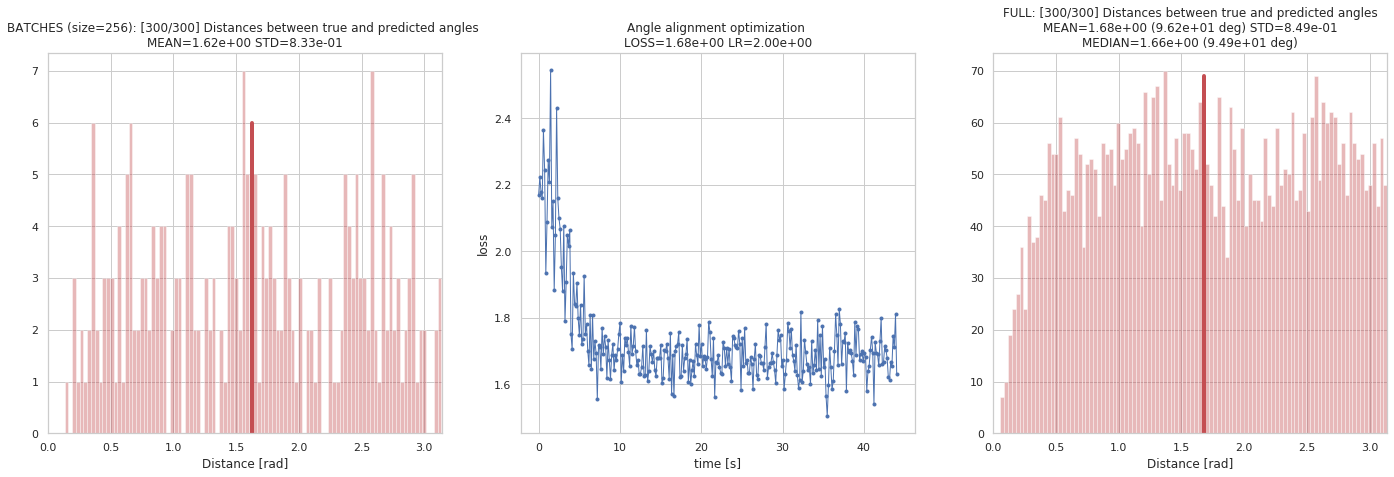

step 30/300 (4s): loss = 2.09e+00
step 60/300 (9s): loss = 1.74e+00
step 90/300 (13s): loss = 1.69e+00
step 120/300 (19s): loss = 1.67e+00
step 150/300 (23s): loss = 1.68e+00
step 180/300 (28s): loss = 1.68e+00
step 210/300 (32s): loss = 1.68e+00
step 240/300 (36s): loss = 1.68e+00
step 270/300 (41s): loss = 1.69e+00
step 300/300 (45s): loss = 1.68e+00



In [46]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=angles_true, 
                                                        angles_predicted=angles_predicted_dc)

In [47]:
# 1.609
losses[-1], m, a_R

(1.6020859078332,
 [1.0, 1.0, 1.0, -1.0],
 [<tf.Variable 'Variable:0' shape=(6,) dtype=float64, numpy=
  array([ 10.08960816,  20.14364272, -28.61143607, -15.79061614,
         -27.67136221, -28.05676016])>])

In [48]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)

angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

np.save("data/5j0n/angles_predicted_full_rotated_limited3.14_estimated_50k", angles_predicted_rotated)

In [36]:
plot_iterations_polar_plot(collect_data, angles_true, interval=200, connections=False, selected=None)

In [66]:
# ipv.screenshot()

In [50]:
plot_iterations_rotvec(collect_data, np.zeros(angles_true.shape), interval=200)

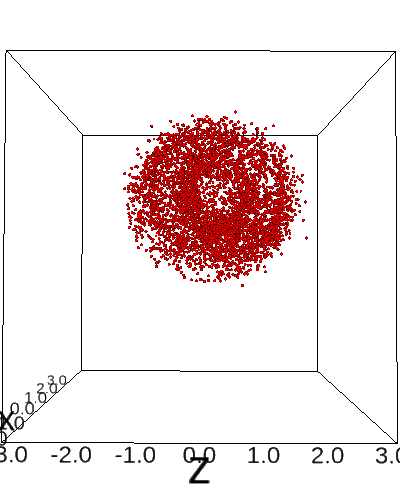

In [51]:
plot_rotvec(angles_predicted_rotated.numpy())

In [52]:
ipv.screenshot()

Output()

In [48]:
plot_rotvec(angles_transpose(angles_predicted_rotated.numpy()))

In [56]:
plot_euclidean_space(angles_true)

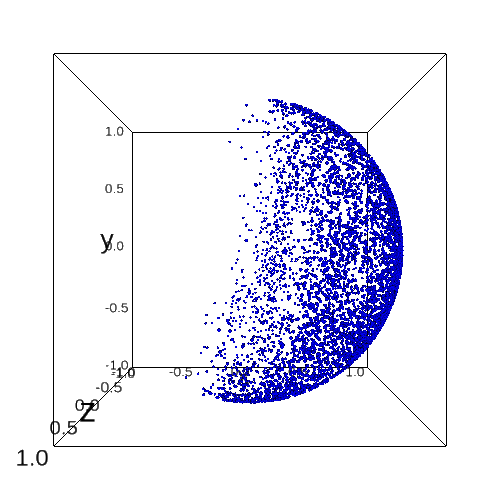

In [43]:
plot_euclidean_space(angles_predicted_rotated)

In [44]:
ipv.screenshot()

Output()

In [42]:
plot_only_selected_in_euclidean_space(angles_predicted_rotated, angles_true, selected=range(100))